In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
from scipy.stats import ortho_group

import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.linear_model import RidgeCV, LinearRegression

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)

## Ridge

## Plot Results from files

In [2]:
file = open('ridge_identity_bias_variance.txt', 'rb')
results_identity = pickle.load(file)
file.close()

file = open('ridge_singular_bias_variance.txt', 'rb')
results_singular = pickle.load(file)
file.close()

In [3]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [12]:
results_identity["ds"]

[400]

In [6]:
results_identity.keys()

dict_keys(['ns', 'ds', 'gammas', 'num_trials', 'beta_norm', 'mse_test', 't_pred_variance', 't_pred_bias', 'ols_test', 'ols_pred_variance', 'ols_pred_bias', 'mse', 't_variance', 't_bias', 'ols_mse', 'ols_variance', 'ols_bias'])

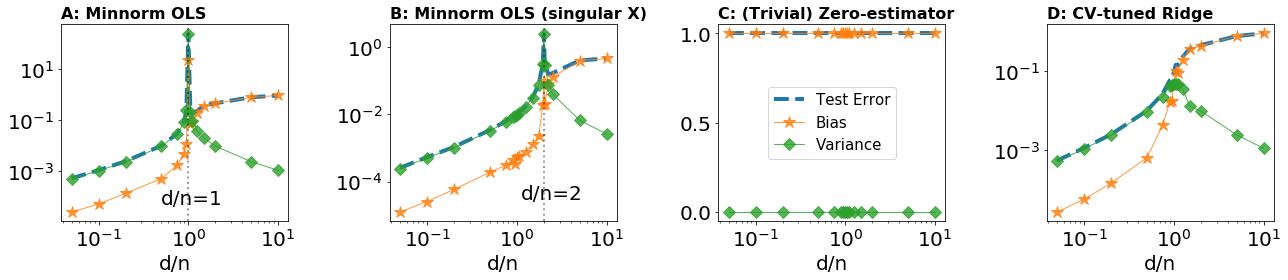

In [11]:
plt.figure(figsize=[18, 4])
for j, d in enumerate(results_identity['ds']):
    plt.subplot(1, 4, 4)
    plt.title('D: CV-tuned Ridge', fontweight='bold', loc='left', fontsize=16)
    plt.loglog(results_identity["gammas"], results_identity["mse_test"].mean(0)[j, :], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(results_identity["gammas"], results_identity["t_pred_bias"][j, :], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=12, alpha=.8)
    plt.loglog(results_identity["gammas"], results_identity["t_pred_variance"][j, :], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=8, alpha=.8)
    
#     plt.title("Ridge-CV (Identity)", fontsize=20)
    plt.xlabel('d/n')
    
    plt.subplot(1, 4, 1)
    plt.title('A: Minnorm OLS', fontweight='bold', loc='left', fontsize=16)
    plt.loglog(results_identity["gammas"], results_identity["ols_test"].mean(0)[j, :], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(results_identity["gammas"], results_identity["ols_pred_bias"][j, :], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=12, alpha=.8)
    plt.loglog(results_identity["gammas"], results_identity["ols_pred_variance"][j, :], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=8, alpha=.8)
    plt.axvline(1., color='k', linestyle=':', linewidth=2., alpha=0.4)
    
    plt.text(.5, 0.5e-4, s='d/n=1', fontsize=20)
#     plt.title("Min. Norm OLS", fontsize=20)
    plt.xlabel('d/n')
#     plt.legend()

    plt.subplot(1, 4, 3)
    plt.title('C: (Trivial) Zero-estimator', fontweight='bold', loc='left', fontsize=16)
    plt.semilogx(results_identity["gammas"], results_identity["beta_norm"]*np.ones_like(results_identity["gammas"]), label='Test Error', linestyle='--', linewidth=4.)
    plt.semilogx(results_identity["gammas"], results_identity["beta_norm"]*np.ones_like(results_identity["gammas"]), label='Bias', linestyle='-', linewidth=1, marker='*', markersize=12, alpha=.8)
    plt.semilogx(results_identity["gammas"], np.zeros_like(results_identity["gammas"]), label='Variance', linestyle='-', linewidth=1, marker='D', markersize=8, alpha=.8)
    
#     plt.title("The Zero-estimator",  fontsize=20)
    plt.legend(loc="center", fontsize=15)
    plt.xlabel('d/n')
#     plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.title('B: Minnorm OLS (singular X)', fontweight='bold', loc='left', fontsize=16)
    plt.loglog(results_singular["gammas"], results_singular["ols_test"].mean(0)[j, :], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(results_singular["gammas"], results_singular["ols_pred_bias"][j, :], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=12, alpha=.8)
    plt.loglog(results_singular["gammas"], results_singular["ols_pred_variance"][j, :], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=8, alpha=.8)
    plt.axvline(2., color='k', linestyle=':', linewidth=2., alpha=0.4)
    plt.text(1.1, 3e-5, s='d/n=2', fontsize=20)
    plt.xlabel('d/n')    

plt.tight_layout()
plt.savefig('all_bias_variance.pdf')
plt.show()


## Run to get results

In [ ]:

npr.seed(0)
num_trials = 20
# gammas = np.array([5e-2, 1e-1, 0.2, 0.5, 0.75, 0.9, 0.95, 1.,  1.05,  1.1,  1.25, 1.5, 2., 5., 10.])
gammas = np.array([5e-2, 1e-1, 0.2, 0.5, 0.75, 0.9, 0.95, 1.,  1.05,  1.25, 1.5,  1.75, 1.95, 2., 2.05, 2.25, 2.5, 5., 10.])

noise_std = .1
n_test = 5000

ds = [400]
ns = np.asarray(ds[0]/gammas, dtype=int)

ols_train = np.zeros((num_trials, len(ds), len(ns)))
ols_test = np.zeros((num_trials, len(ds), len(ns)))
ols_mse_beta = np.zeros((num_trials, len(ds), len(ns)))
ols_bias = np.zeros((len(ds), len(ns)))
ols_variance = np.zeros((len(ds), len(ns))) 
ols_pred_bias = np.zeros((len(ds), len(ns)))
ols_pred_variance = np.zeros((len(ds), len(ns)))


mse_train = np.zeros((num_trials, len(ds), len(ns)))
mse_test = np.zeros((num_trials, len(ds), len(ns)))
mse_beta = np.zeros((num_trials, len(ds), len(ns)))
t_bias  = np.zeros((len(ds), len(ns)))
t_variance = np.zeros((len(ds), len(ns)))
t_pred_bias = np.zeros((len(ds), len(ns)))
t_pred_variance = np.zeros((len(ds), len(ns)))


## choice of singular or not, just change this prefix
prefix = 'ridge_identity_sigma_%d_'%noise_std
# prefix = 'ridge_singular_sigma_%d_'%noise_std ##

for j, d in enumerate(ds):
    ns = np.asarray(np.maximum(2, d/gammas), dtype=int)

    for k, n in enumerate(ns):
        tvars = np.zeros((num_trials, d))
        ols_vars = np.zeros((num_trials, d))
        
        t_preds = np.zeros((num_trials, n_test))
        ols_preds = np.zeros((num_trials, n_test))
        
        beta_star = npr.randn(d)
        beta_star /= npl.norm(beta_star)
        beta_star *= 1. #
        X_train = npr.randn(n, d)
        X_test = npr.randn(n_test, d)
        if 'singular' in prefix:
            X_train = X_train @ np.diag(np.hstack((np.ones(int(d/2)), np.zeros(int(d/2)))))
            X_test = X_test @ np.diag(np.hstack((np.ones(int(d/2)), np.zeros(int(d/2)))))

        for i in range(num_trials):
            if i==0:
                print(i, d, n)
                
            y_train = X_train @ beta_star + noise_std * npr.randn(n)
            y_test =  X_test @ beta_star #+ noise_std *  npr.randn(n_test)
            
            m = RidgeCV(fit_intercept=False, alphas=np.logspace(-4, 4, num=40, base=10))
            m.fit(X_train, y_train)
            tvars[i, :] = m.coef_
            t_preds[i, :] = X_test @ m.coef_
            
            mse_train[i, j, k] = npl.norm(y_train - X_train @ m.coef_)**2 / n
            mse_test[i, j, k] = npl.norm(y_test - t_preds[i, :])**2 /  n_test
            mse_beta[i, j, k] = npl.norm(m.coef_-beta_star)**2
                        
            ols = LinearRegression(fit_intercept=False)
            ols.fit(X_train, y_train)
            ols_vars[i, :] = ols.coef_
            ols_preds[i, :] = X_test @ ols.coef_
            
            ols_train[i, j, k] = npl.norm(y_train - X_train @ tols)**2 / n
            ols_test[i, j, k] = npl.norm(y_test - ols_preds[i, :])**2 / n_test
            ols_mse_beta[i, j, k] = npl.norm(ols.coef_-beta_star)**2
        
        tmean = tvars.mean(0)
        t_variance[j, k] = np.sum((tvars - tmean)**2)/num_trials
        t_bias[j, k] = np.sum((tmean - beta_star)**2)
        
        pmean = t_preds.mean(0)
        t_pred_variance[j, k] = np.sum((t_preds - pmean)**2)/num_trials/n_test
        t_pred_bias[j, k]  = np.sum((pmean-y_test)**2)/n_test
        
        tmean = ols_vars.mean(0)
        ols_variance[j, k] = np.sum((ols_vars - tmean)**2)/num_trials
        ols_bias[j, k] = np.sum((tmean- beta_star)**2)
        
        pmean = ols_preds.mean(0)
        ols_pred_variance[j, k] = np.sum((ols_preds - pmean)**2)/num_trials/n_test
        ols_pred_bias[j, k]  = np.sum((pmean - y_test)**2)/n_test

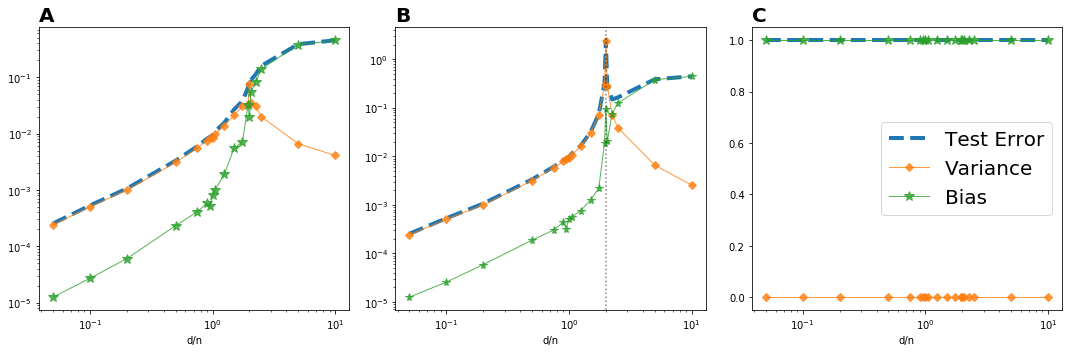

In [111]:
plt.figure(figsize=[15, 5])
for j, d in enumerate(ds):
    plt.subplot(1, 3, 1)
    plt.loglog(gammas, mse_test.mean(0)[j, :], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(gammas, t_pred_variance[j, :], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.loglog(gammas, t_pred_bias[j, :], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=10, alpha=.8)
    plt.title('A', fontweight='bold', loc='left', fontsize=20)
#     plt.title("Ridge Regression", fontsize=20)
    plt.xlabel('d/n')
    
    plt.subplot(1, 3, 2)
    plt.loglog(gammas, ols_test.mean(0)[j, :], label='Test Error', linestyle='--', linewidth=4.)
    plt.loglog(gammas, ols_pred_variance[j, :], label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.loglog(gammas, ols_pred_bias[j, :], label='Bias', linestyle='-', linewidth=1, marker='*', markersize=8, alpha=.8)
    plt.axvline(2., color='k', linestyle=':', alpha=0.5)
    plt.title('B', fontweight='bold', loc='left', fontsize=20)
#     plt.title("Min. Norm OLS", fontsize=20)
    plt.xlabel('d/n')
#     plt.legend()

    plt.subplot(1, 3, 3)
    plt.semilogx(gammas, npl.norm(beta_star)*np.ones_like(gammas), label='Test Error', linestyle='--', linewidth=4.)
    plt.semilogx(gammas, np.zeros_like(gammas), label='Variance', linestyle='-', linewidth=1, marker='D', markersize=5, alpha=.8)
    plt.semilogx(gammas, npl.norm(beta_star)*np.ones_like(gammas), label='Bias', linestyle='-', linewidth=1, marker='*', markersize=10, alpha=.8)
    plt.title('C', fontweight='bold', loc='left', fontsize=20)
#     plt.title("The Zero-estimator",  fontsize=20)
    plt.xlabel('d/n')
    plt.legend()
plt.tight_layout()
# plt.savefig(prefix+'bias_variance.pdf')
plt.show()


## save results

In [119]:
file_name = prefix+'bias_variance.txt'

results = {'ns': ns, 'ds': ds, 'gammas': gammas, 'num_trials': num_trials, 'beta_norm': npl.norm(beta_star),  
           'mse_test': mse_test, 't_pred_variance': t_pred_variance, 't_pred_bias':t_pred_bias,
           'ols_test': ols_test, 'ols_pred_variance': ols_pred_variance, 'ols_pred_bias':ols_pred_bias,
           
           'mse': mse_beta, 't_variance': t_variance, 't_bias':t_bias,
           'ols_mse': ols_mse_beta, 'ols_variance': ols_variance, 'ols_bias':ols_bias,
          }
#     'mdl_practice': mdl_practice, 'mdl_theory_lam': mdl_theory_lam, 'mdl_theory':mdl_theory,  'mdl_theory_mean': mdl_theory_mean}
file = open(file_name, 'wb')
pickle.dump(results, file)
file.close()